# Chinese OCR

---

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from alfred.utils.log import logger as logging
from tensorflow.keras.applications import EfficientNetB0
import pickle
import random

In [2]:
# load character mapping
this_dir = os.path.dirname(os.path.abspath("__file__"))
print(this_dir)

def load_characters():
    # a = open(os.path.join(this_dir, 'dataset\\characters.txt'), 'r', encoding='utf-8').readlines() # If you are using Windows
    a = open(os.path.join(this_dir, 'data/characters.txt'), 'r').readlines() # If you are using Mac OS
    return [i.strip() for i in a]

all_characters = load_characters()
num_classes = len(all_characters)
print(f'There are {num_classes} classes of chinese characters in the dataset')
logging.info('all characters: {}'.format(num_classes))

20:16:13 10.29 INFO 270619917.py:13]: all characters: 3755


/Users/perrine/Desktop/M2/S1/Documents_Structuré/Chinese_OCR
There are 3755 classes of chinese characters in the dataset


## Load datasets

---

Nous souhaitons charger le jeu de données à partir du fichier local. Le jeu de données est constitué de fichiers `tfrecord` qui contiennent des images, des étiquettes et des informations de résolution pour les images. La raison de l’enregistrement au format `tfrecord` est d’améliorer les performances d’entraînement. En effet, en utilisant un fichiers `csv` contenant le l'image et le label, nos machines n'étaient pas assez puissante pour finir l'entrainement.

- [test.tfrecord](https://drive.google.com/file/d/1GMbnNViYCibVZB3qRO3JTY4flbSzy7AH/view?usp=share_link)
- [train.tfrecord](https://drive.google.com/file/d/1Szs-7udI5vbd_j7y1YXbj_i1SioEzooS/view?usp=share_link)

In [3]:
# Necessary parameters
IMG_SIZE = 80 # This size is fixed for EfficientNetB0

In [4]:
# decode tfrecord to images and labels

def parse_image(record):
    """
    :param record: tfrecord file
    :return: image and label
    """
    features = tf.io.parse_single_example(record,
                                          features={
                                              'width':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'height':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'label':
                                                  tf.io.FixedLenFeature([], tf.int64),
                                              'image':
                                                  tf.io.FixedLenFeature([], tf.string),
                                          })
    img = tf.io.decode_raw(features['image'], out_type=tf.uint8)
    w = features['width']
    h = features['height']
    img = tf.cast(tf.reshape(img, (w, h)), dtype=tf.float32)
    label = tf.cast(features['label'], tf.int64)
    return {'image': img, 'label': label}

def load_datasets(filename):
    """
    :param filename: tfrecord file
    :return: dataset
    """
    dataset = tf.data.TFRecordDataset([filename])
    dataset = dataset.map(parse_image)
    return dataset

### Explore datasets
In this part, we can see what are the datasets look like. 

In [5]:
train_ds = load_datasets('data/train.tfrecord')
test_ds = load_datasets('data/test.tfrecord')

train_mapped = train_ds.shuffle(100).batch(32).repeat()
test_mapped = test_ds.batch(32).repeat()
train_mapped

2024-10-29 20:16:13.178051: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-29 20:16:13.178079: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-29 20:16:13.178084: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-29 20:16:13.178133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-29 20:16:13.178152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<_RepeatDataset element_spec={'image': TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

In [6]:
# summary information of the dataset, plot the width and height of the images
shapes_plot_train = [[], []]
shapes_plot_test = [[], []]
for i in train_ds:
    shapes_plot_train[0].append(i['image'].shape[0])
    shapes_plot_train[1].append(i['image'].shape[1])

for i in test_ds:
    shapes_plot_test[0].append(i['image'].shape[0])
    shapes_plot_test[1].append(i['image'].shape[1])

In [7]:
# show the number of pictures in the dataset
print(f'There are {len(shapes_plot_train[0])} pictures in the training dataset')
print(f'There are {len(shapes_plot_test[0])} pictures in the testing dataset')

There are 897758 pictures in the training dataset
There are 223991 pictures in the testing dataset


In [8]:
def plot_info_dataset(shapes_plot):
    # plot the histogram of the width and height of the images, and the third plot is the scatter plot
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].hist(shapes_plot[0], bins=100)
    ax[0].set_title('width')
    ax[0].set_xlabel('pixels')
    ax[0].set_ylabel('frequency')
    ax[1].hist(shapes_plot[1], bins=100)
    ax[1].set_title('height')
    ax[0].set_xlabel('pixels')
    ax[0].set_ylabel('frequency')
    ax[2].scatter(shapes_plot[0], shapes_plot[1])
    ax[2].set_title('width vs height')
    ax[2].set_xlabel('width (pixels)')
    ax[2].set_ylabel('height (pixels)')
    plt.show()

------------------- Information of training dataset -------------------


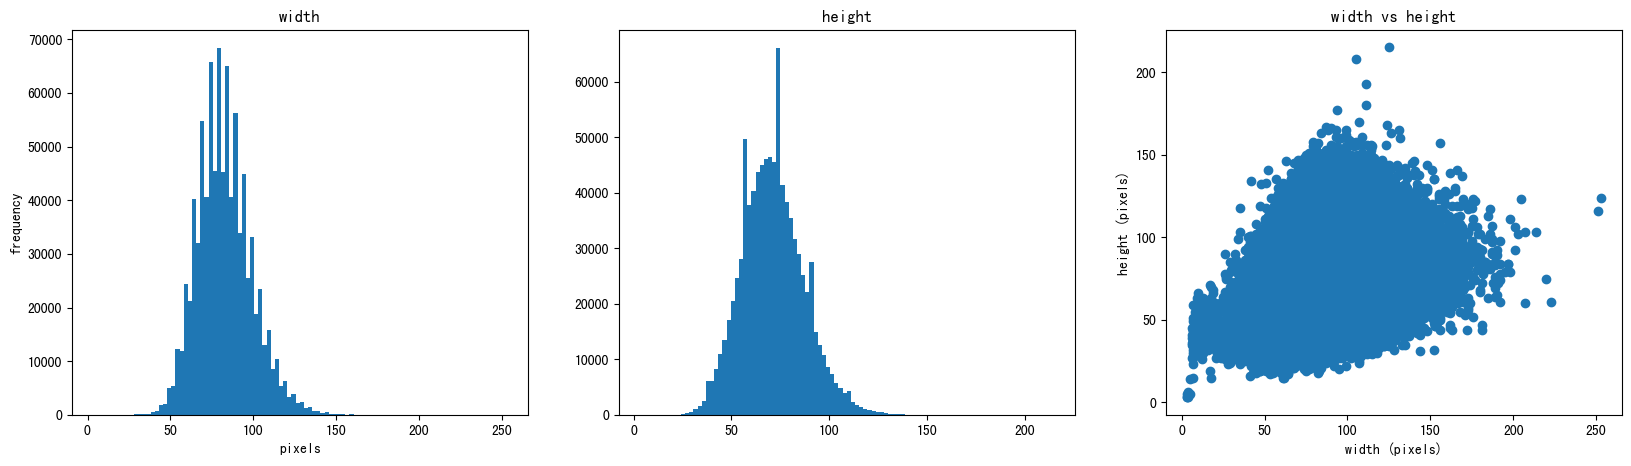

------------------- Information of testing dataset -------------------


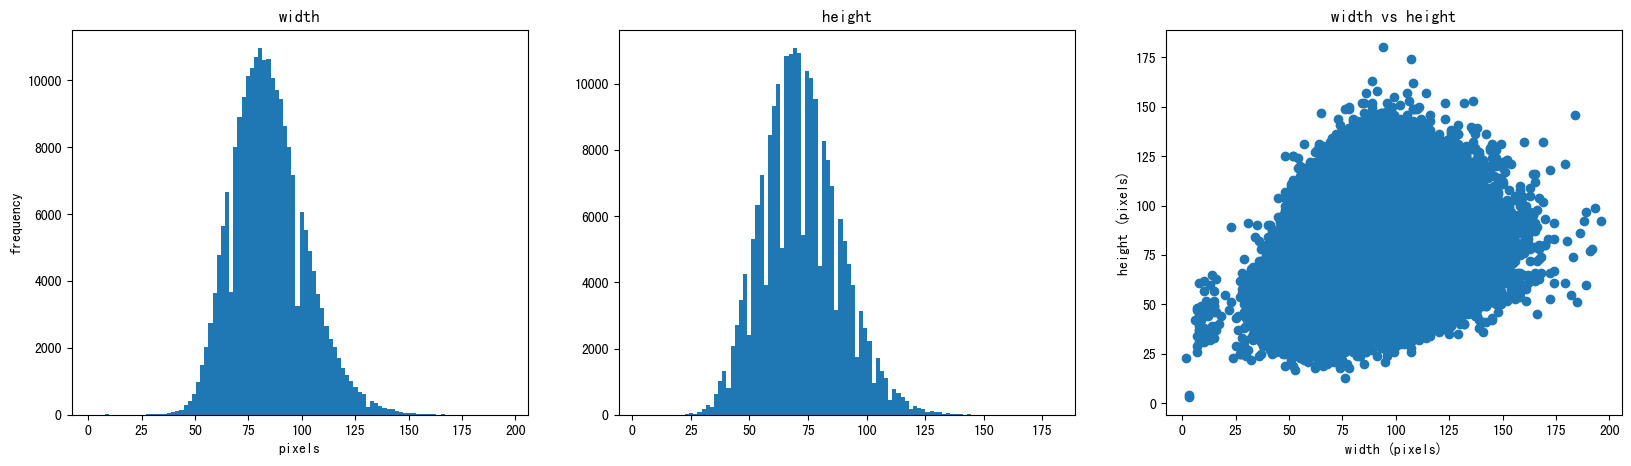

In [9]:
print('------------------- Information of training dataset -------------------')
plot_info_dataset(shapes_plot_train)
print('------------------- Information of testing dataset -------------------')
plot_info_dataset(shapes_plot_test)

Nous pouvons également tracer quelques images et étiquettes à partir des jeux de données.

In [10]:
# default_font = FontProperties()
def plot_img(ds, characters, num =9):
    plt.rcParams["font.sans-serif"]=["SimHei"] #Set font to avoid garbled characters
    plt.rcParams["axes.unicode_minus"]=False # The same as above
    ax, fig = plt.subplots(3, 3, figsize=(12, 12))
    for i, data in enumerate(ds.take(num)):
        img = data['image'].numpy()
        label = data['label'].numpy()
        fig[i//3][i%3].imshow(img, cmap='gray')
        fig[i//3][i%3].set_title(f'label: {characters[label]}, size: {img.shape}', fontsize=15)
    
    plt.show()

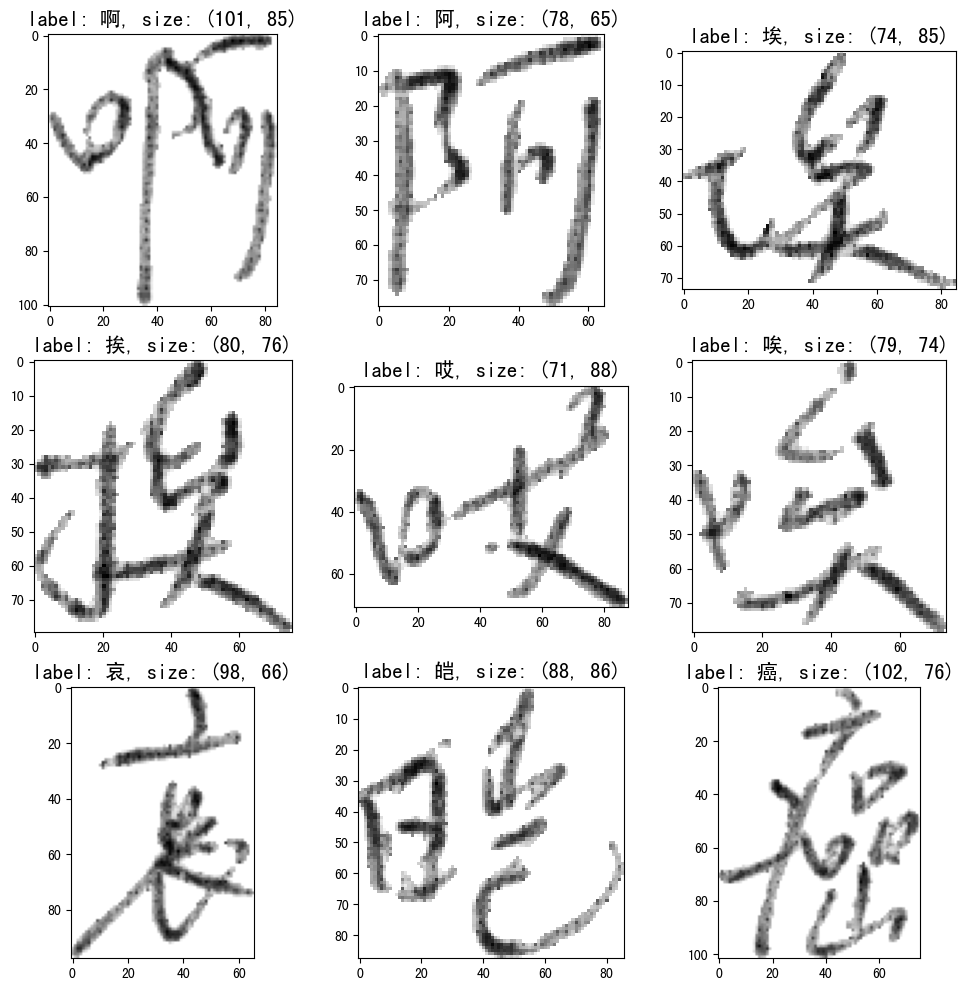

In [11]:
plot_img(train_ds, all_characters, num=9)

## Training - With Simple CNN Model

---

Dans cette partie, nous allons définir les modèles et les fonctions d’entraînement. 

Dans la `première` partie, nous allons commencer par un modèle CNN simple.

In [12]:
# some basic parameters
TARGET_SIZE = 64
IMG_SIZE = 224 # This size is fixed for EfficientNetB0
ckpt_path = './model/checkpoints/simple_net/cn_ocr-{epoch}.ckpt'
train_path = './data/train.tfrecord'
test_path = './data/test.tfrecord'

In [13]:
# image preprocessing
def preprocess(ds):
    """
    :param ds: dataset
    :return: image and label
    """
    ds['image'] = tf.expand_dims(ds['image'], axis=-1)
    ds['image'] = tf.image.resize(ds['image'], (TARGET_SIZE, TARGET_SIZE))
    ds['image'] = (ds['image'] - 128.) / 128.
    return ds['image'], ds['label']

In [14]:
# history log callback function
#
# This part is used to collecting the training statics and save them into a file.
#
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, history_path):
        super().__init__()
        self.history_path = history_path
        if os.path.exists(self.history_path):
            with open(self.history_path, 'rb') as f:
                self.history = pickle.load(f)
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key in logs:
            if key in self.history:
                self.history[key].append(logs[key])
            else:
                self.history[key] = [logs[key]]

    def on_train_end(self, logs=None):
        with open(self.history_path, 'wb') as f:
            pickle.dump(self.history, f)

In [ ]:
# Define a simple CNN model
def simple_net(input_shape, n_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(input_shape=input_shape, filters=32, kernel_size=(3, 3), strides=(1, 1),
                      padding='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        layers.Flatten(),
        # layers.Dense(1024, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model


In [16]:
# show the summary of the model
model = simple_net((TARGET_SIZE, TARGET_SIZE, 1), len(all_characters))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 3755)              6

### Training

In [18]:
def train_simple():
    print(f'number of classes: {num_classes}')

    history_path = 'model/history_simple.pickle'
    save_history_callback = SaveHistoryCallback(history_path)

    train_dataset = load_datasets(train_path)
    test_dataset = load_datasets(test_path)

    train_dataset = train_dataset.map(preprocess).shuffle(100).batch(32).repeat()
    test_dataset = test_dataset.shuffle(100).map(preprocess).batch(32)

    print(f'train dataset: {train_dataset}')

    # build model
    model = simple_net((TARGET_SIZE, TARGET_SIZE, 1), num_classes)
    model.summary()

    # latest checkpoints
    latest_ckpt = tf.train.latest_checkpoint(os.path.dirname(ckpt_path))
    if latest_ckpt:
        print(f'model resumed from: {latest_ckpt}')
        model.load_weights(latest_ckpt)
    else:
        print('training from scratch')
        
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                            save_weights_only=True,
                                            verbose=1,
                                            save_freq='epoch',
                                            save_best_only=True),
        save_history_callback
    ]
    try:
        model.fit(
            train_dataset,
            validation_data=test_dataset,
            validation_steps=1000,
            epochs=100,
            steps_per_epoch=1024,
            callbacks=callbacks)
    except KeyboardInterrupt:
        logging.info('keras model saved. KeyboardInterrupt')
        save_history_callback.on_train_end()
        return model 
    
    model.save_weights(ckpt_path.format(epoch=0))
    model.save(os.path.join(os.path.dirname(ckpt_path), 'cn_ocr_simple.keras'))
    logging.info('All epoch finished. keras model saved.')
    return model

In [19]:
# train the model (computation heavy)
# model = train_simple()

### Evaluation and  Prediction visualization

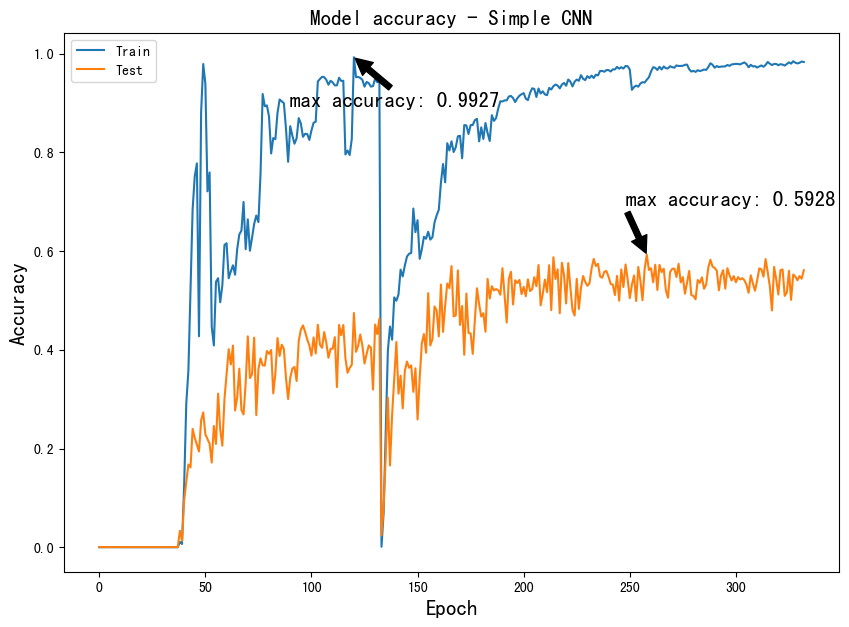

In [20]:
with open('model/history_simple.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.figure(figsize=(10, 7))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy - Simple CNN', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper left')

# show the highest accuracy in the graph
max_acc = max(history['val_accuracy'])
plt.annotate(f'max accuracy: {max_acc:.4f}', xy=(np.argmax(history['val_accuracy']), max_acc),
                xytext=(np.argmax(history['val_accuracy']) - 10, max_acc + 0.1),
                arrowprops=dict(facecolor='black', shrink=0.03), fontsize=15)
max_acc_train = max(history['accuracy'])
plt.annotate(f'max accuracy: {max_acc_train:.4f}', xy=(np.argmax(history['accuracy']), max_acc_train),
                xytext=(np.argmax(history['accuracy']) - 30, max_acc_train - 0.1),
                arrowprops=dict(facecolor='black', shrink=0.03), fontsize=15)
plt.show()

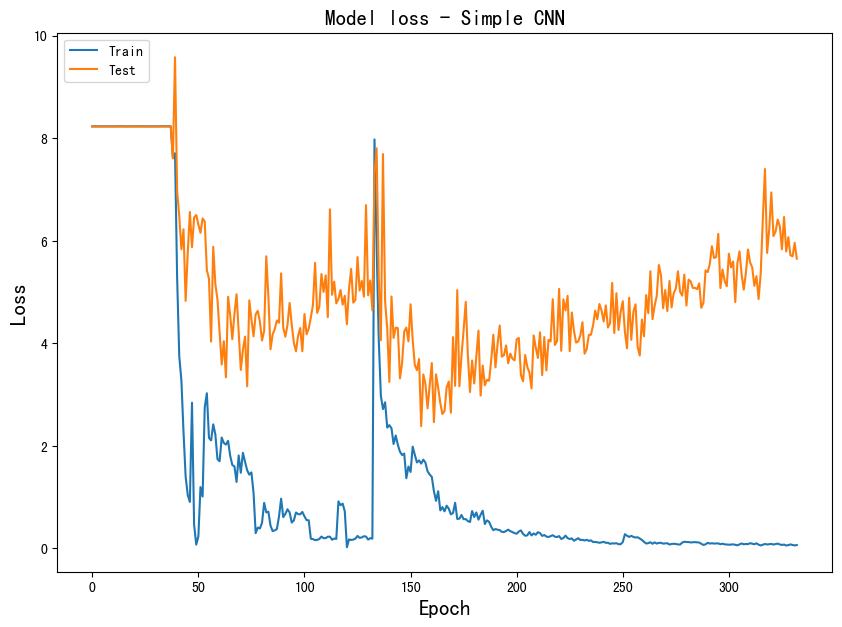

In [21]:
# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss - Simple CNN', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
# Load the best model
model = simple_net((TARGET_SIZE, TARGET_SIZE, 1), num_classes)
# model.load_weights(tf.train.latest_checkpoint(os.path.dirname(ckpt_path)))
model.load_weights('model/checkpoints/simple_net/cn_ocr-26.ckpt')

In [24]:
# display the result
import random

def display_result(model, ds, characters):
    ds = ds.shuffle(100).map(preprocess).batch(32).repeat()
    f, axe = plt.subplots(3, 3, figsize=(15, 15))
    plt.rcParams["font.sans-serif"]=["SimHei"] #Set font to avoid garbled characters
    plt.rcParams["axes.unicode_minus"]=False # The same as above
    # take 9 samples
    for data in ds.take(1):
        images, labels = data
        predictions = model.predict(images)
        for i in range(9):
            axe[i//3, i%3].imshow(images[i].numpy().reshape(64, 64), cmap='gray')
            axe[i//3, i%3].axis('on')
            axe[i//3, i%3].set_title(f'pred: {characters[np.argmax(predictions[i])]}, label: {characters[labels[i]]}, Is Correct: {np.argmax(predictions[i]) == labels[i]}')
    plt.show()

2024-10-29 20:19:34.113406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 852ms/step


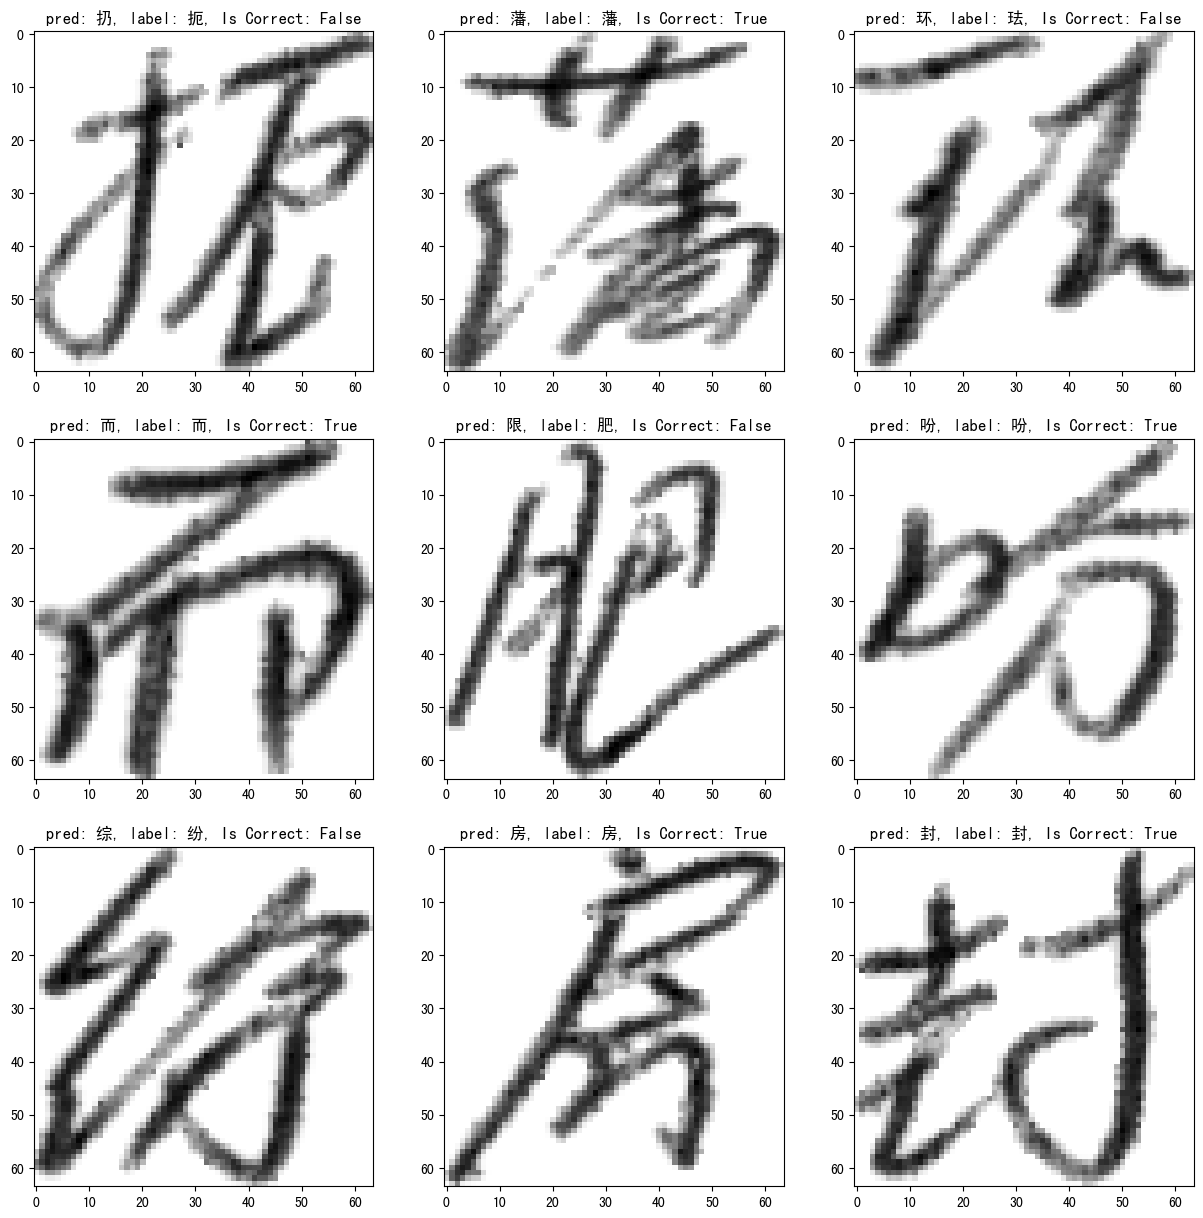

In [25]:
test_ds = load_datasets(test_path)
display_result(model, test_ds, all_characters)

In [26]:
print("Accuracy of the model: ", max(history['val_accuracy']))
print("Loss of the model: ", min(history['val_loss']))

Accuracy of the model:  0.5927812457084656
Loss of the model:  2.385397434234619


## Refine the Model with EfficientNet

---

Ce modèle ne parvient à atteindre qu’une précision de validation d’environ 60%, ce qui n’est pas satisfaisant pour nous. Nous avons donc décidé d’utiliser un modèle bien plus complexe appelé EfficientNet pour l’entraînement. Ce modèle est un modèle de pointe pour la classification d’images. Nous allons utiliser la version B0 du modèle. Pour plus d’informations sur le modèle, veuillez consulter cet [article](https://arxiv.org/pdf/1905.11946.pdf) et cette [page web](https://www.kaggle.com/code/lys620/efficientnet-with-keras).

In [27]:
# some basic parameters
IMG_SIZE = 224 # This size is fixed for EfficientNetB0
ckpt_path = './model/checkpoints/efficient_net/cn_ocr-{epoch}.ckpt'
train_path = './data/train.tfrecord'
test_path = './data/test.tfrecord'

In [28]:
def preprocess_efficientnet(ds):
    """
    :param ds: dataset
    :return: image and label

    No normalization is needed here for EfficientNetB0
    """
    ds['image'] = tf.expand_dims(ds['image'], axis=-1)
    ds['image'] = tf.image.grayscale_to_rgb(ds['image'])
    ds['image'] = tf.image.resize(ds['image'], (IMG_SIZE, IMG_SIZE))
    return ds['image'], ds['label']

In [29]:
# model
def effcientnetB0_model():
    # EfficientNetB0 expects 3 channels
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(
        include_top=False, input_tensor=inputs, weights='imagenet')
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=x)
    return model

In [30]:
# model summary of EfficientNetB0
model = effcientnetB0_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [31]:
def train_efficientnet():
    print(f'number of classes: {num_classes}')

    history_path = './model/history_efficientnet.pickle'
    save_history_callback = SaveHistoryCallback(history_path)

    train_dataset = load_datasets(train_path)
    test_dataset = load_datasets(test_path)

    train_dataset = train_dataset.map(preprocess_efficientnet).shuffle(100).batch(32).repeat()
    test_dataset = test_dataset.shuffle(100).map(preprocess_efficientnet).batch(32).repeat()

    print(f'train dataset: {train_dataset}')

    # build model
    model = effcientnetB0_model()
    # model.summary() # too long to display

    # latest checkpoints
    latest_ckpt = tf.train.latest_checkpoint(os.path.dirname(ckpt_path))
    if latest_ckpt:
        print(f'model resumed from: {latest_ckpt}')
        model.load_weights(latest_ckpt)
    else:
        print('training from scratch')
        
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                            save_weights_only=True,
                                            verbose=1,
                                            save_freq='epoch',
                                            save_best_only=True),
        save_history_callback
    ]
    try:
        model.fit(
            train_dataset,
            validation_data=test_dataset,
            validation_steps=1000,
            epochs=100,
            steps_per_epoch=1024,
            callbacks=callbacks,
            use_multiprocessing=True)
    except KeyboardInterrupt:
        logging.info('keras model saved. KeyboardInterrupt')
        save_history_callback.on_train_end()
        return model 
    
    model.save_weights(ckpt_path.format(epoch=0))
    model.save(os.path.join(os.path.dirname(ckpt_path), 'cn_ocr_eff.keras'))
    logging.info('All epoch finished. keras model saved.')
    return model

In [ ]:
# train the model (computation heavy)
# model = train_efficientnet()

number of classes: 3755
train dataset: <RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
model resumed from: ./checkpoints/efficient_net\cn_ocr-0.ckpt
Epoch 1/100
1024/1024 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9880
Epoch 1: val_loss improved from inf to 0.41414, saving model to ./checkpoints/efficient_net\cn_ocr-1.ckpt
1024/1024 [==============================] - 239s 227ms/step - loss: 0.0417 - accuracy: 0.9880 - val_loss: 0.4141 - val_accuracy: 0.9053
Epoch 2/100
1024/1024 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9919
Epoch 2: val_loss improved from 0.41414 to 0.35379, saving model to ./checkpoints/efficient_net\cn_ocr-2.ckpt
1024/1024 [==============================] - 231s 225ms/step - loss: 0.0321 - accuracy: 0.9919 - val_loss: 0.3538 - val_accuracy: 0.9200
Epoch 3/100
1024/1024 [==============================] - ET

16:18:01 10.29 INFO 255791740.py:56]: All epoch finished. keras model saved.


### Evaluaton and  Prediction visualization

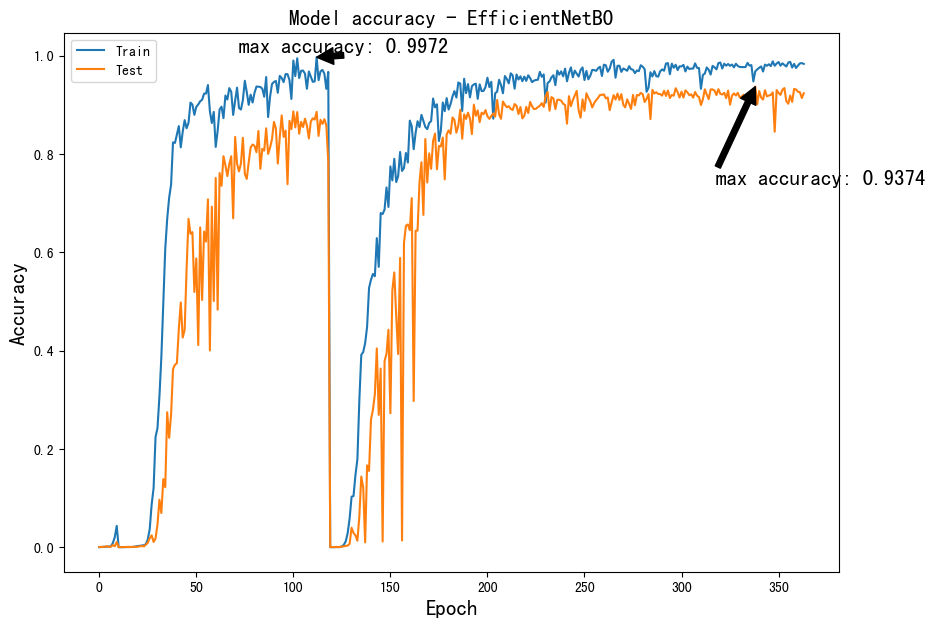

In [32]:
with open('./model/history_efficientnet.pickle', 'rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.figure(figsize=(10, 7))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy - EfficientNetB0', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper left')

# show the highest accuracy in the graph
max_acc = max(history['val_accuracy'])
plt.annotate(f'max accuracy: {max_acc:.4f}', xy=(np.argmax(history['val_accuracy']), max_acc),
                xytext=(np.argmax(history['val_accuracy']) - 20, max_acc - 0.2),
                arrowprops=dict(facecolor='black', shrink=0.001), fontsize=15)
max_acc_train = max(history['accuracy'])
plt.annotate(f'max accuracy: {max_acc_train:.4f}', xy=(np.argmax(history['accuracy']), max_acc_train),
                xytext=(np.argmax(history['accuracy']) - 40, max_acc_train + 0.01),
                arrowprops=dict(facecolor='black', shrink=0.001), fontsize=15)
plt.show()

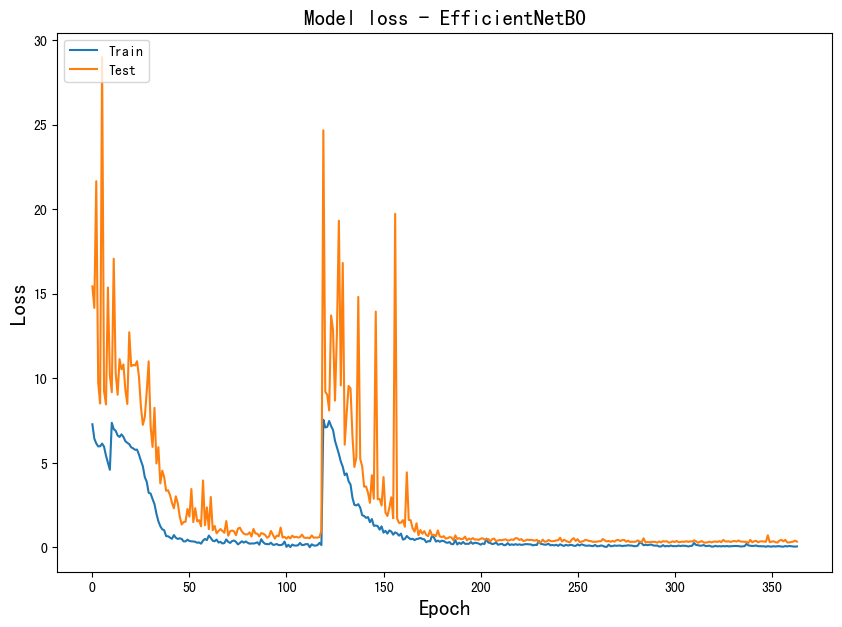

In [33]:
# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss - EfficientNetB0', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
# Load the best model
model = effcientnetB0_model()
# model.load_weights(tf.train.latest_checkpoint(os.path.dirname(ckpt_path)))
model.load_weights('model/checkpoints/efficient_net/cn_ocr-75.ckpt')

In [35]:
def display_result(model, ds, characters):
    ds = ds.shuffle(100).map(preprocess_efficientnet).batch(32).repeat()
    _, axe = plt.subplots(3, 3, figsize=(15, 15))
    plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
    for _, data in enumerate(ds.take(1)):
        images, labels = data
        predictions = model.predict(images)
        for i in range(9):
            axe[i//3, i%3].imshow(images[i].numpy().astype('uint8'), cmap='gray')
            axe[i//3, i%3].axis('on')
            axe[i//3, i%3].set_title(f'pred: {characters[np.argmax(predictions[i])]}, label: {characters[labels[i]]}, Is correct: {np.argmax(predictions[i]) == labels[i]}')
    plt.show()

2024-10-29 20:20:29.862071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


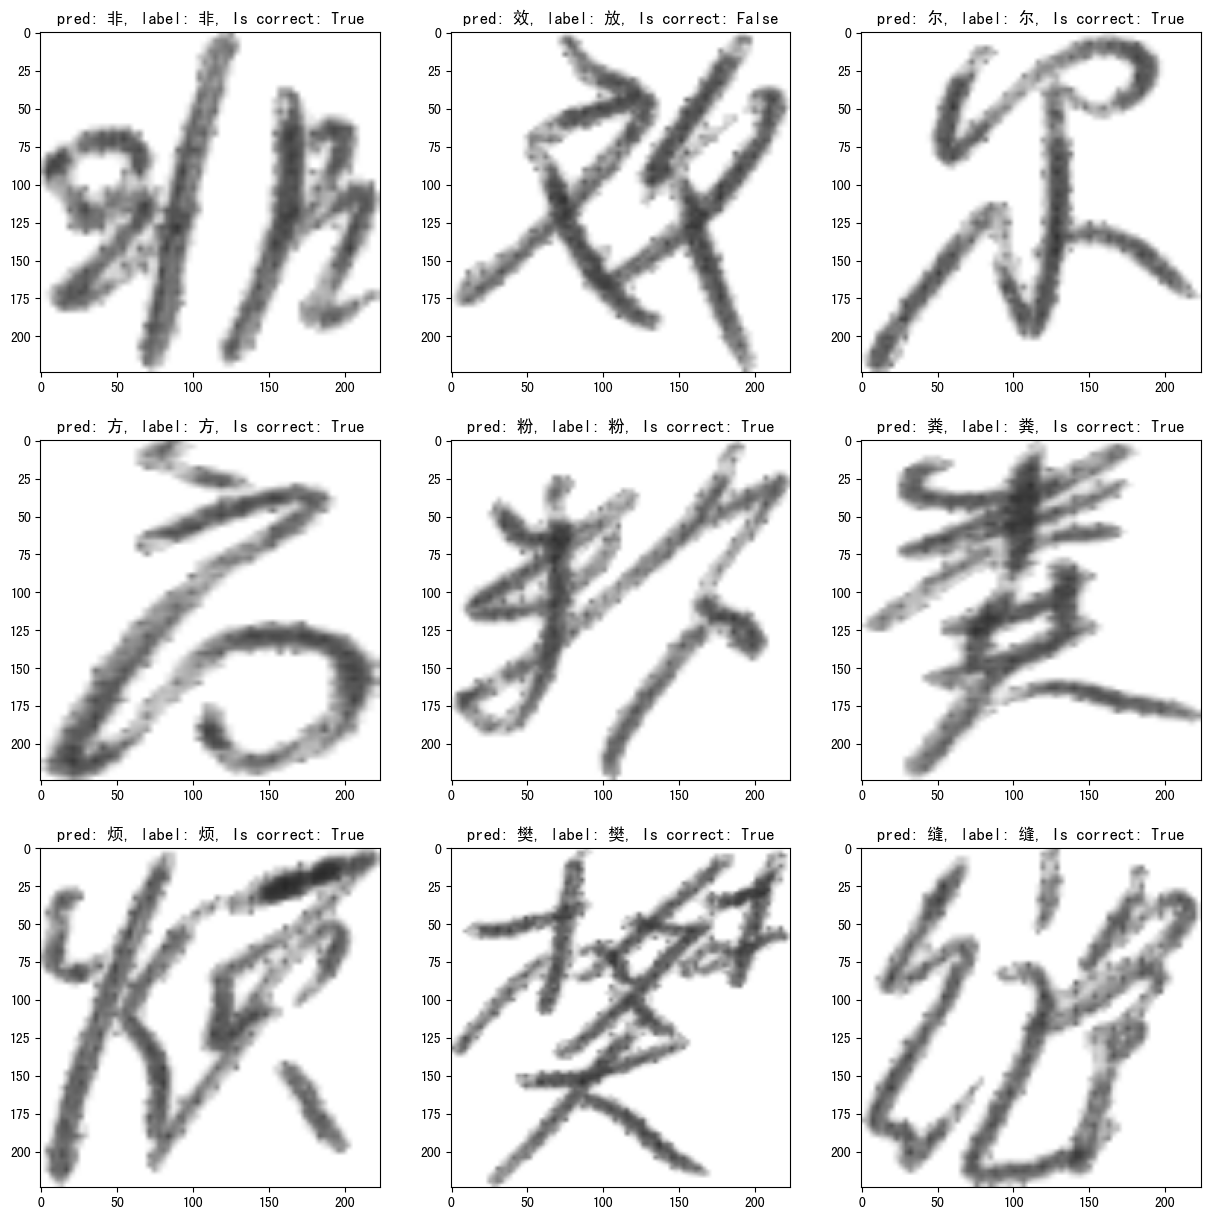

In [36]:
test_ds = load_datasets(test_path)
display_result(model, test_ds, all_characters)

Nous pouvons constater que, pour le modèle avec EfficientNet, la précision de validation peut atteindre **93%** après environ 100 époques, ce qui représente une amélioration significative par rapport au modèle CNN simple.

In [ ]:
print("Accuracy of the model: ", max(history['val_accuracy']))
print("Loss of the model: ", min(history['val_loss']))

path:  model/history_efficientnet.pickle
Accuracy of the model:  0.9374374747276306
Loss of the model:  0.26574471592903137
